In [1]:
import json
import matplotlib.pyplot as plt
import numpy
import math
import seaborn
from sklearn.feature_extraction.text import CountVectorizer
from collections import OrderedDict
%matplotlib inline

plt.style.use('ggplot')

In [2]:
instances_file_train = "clickbait17-validation-170630/instances.jsonl"
truth_file_train     = "clickbait17-validation-170630/truth.jsonl"

In [3]:
# read thr data from files
import json
instances = []
truth = []

with open(instances_file_train, "r") as inf:
    instances = [json.loads(x) for x in inf.readlines()]
with open(truth_file_train, "r") as inf:
    truth = [json.loads(x) for x in inf.readlines()]

In [4]:
# compact relevant data into one list of dicts
dataset = {}

# lists: postText, targetParagraphs, targetCaptions
for i in instances:
    dataset[i['id']] = {'postText': i['postText'], 'targetTitle': i['targetTitle'],
                        'targetDescription': i['targetDescription'], 'targetKeywords': i['targetKeywords'], 
                        'targetParagraphs': i['targetParagraphs'], 'targetCaptions': i['targetCaptions']}

for t in truth:
    dataset[t['id']]['truthMean'] = t['truthMean']


In [5]:
# get list of scores and a list of the postTexts
cb_id_list = numpy.fromiter(iter(dataset.keys()), dtype=numpy.int64)
cb_scores_list = []
cb_feat_postText = []

for i in cb_id_list:
    cb_feat_postText.append(dataset[str(i)]['postText'][0])
    cb_scores_list.append(dataset[str(i)]['truthMean'])

cb_scores = numpy.asarray(cb_scores_list)

In [7]:
from nltk import download
download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
# sanitize text with nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
import string

lemmatizer = WordNetLemmatizer()
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
punctuation = string.punctuation

def preprocess_tokenize(text):
    for token in tokenize(text):
        token = preprocess(token)
        yield token

def tokenize(text):
    return [token for token in tknzr.tokenize(text)] # if token not in string.punctuation]

def pos_tokenize(text):
    token_list = [[token] for token in tknzr.tokenize(text) if token not in string.punctuation]
    return token_list
            
def preprocess(string):
    string = string.lower()
    string = lemmatizer.lemmatize(string)
    if string.endswith("'s"):
        string = string[:-2]
    return string

__More possible features:__
* avarage text/word length in characters per Tweet
* known entitiy count
* noun frequency
* POS Tag frequency
* stop word frequency
* punctuation frequency
* tweet sentiment
* you word list

__POS TAG NGRAMS__

In [7]:
# POS Tag frequencies
from nltk.tag import pos_tag_sents

all_pos_tags = [pos_tag_sents(pos_tokenize(tokens)) for tokens in cb_feat_postText]
tag_list = []
for tweets in all_pos_tags:
    tweet_tokens=""
    for elements in tweets:
        tweet_tokens += elements[0][1] + " "
    tag_list.append(tweet_tokens)

pos_tag_cv = CountVectorizer(ngram_range=(2, 5))
cb_feat_pos_ngrams = pos_tag_cv.fit_transform(tag_list)
print(cb_feat_pos_ngrams.shape) # 2459, 2649

(19538, 87888)


__POS TAG Frequencies__

In [8]:
from collections import OrderedDict
tag_frequency_list = []
for tweets in all_pos_tags:
    tag_freq=OrderedDict({'NN': 0, 'NNS': 0, 'VB': 0, 'IN': 0, 'VBG': 0, 'RB': 0, 'JJ': 0, 'NNP': 0, 'JJS': 0, 
                          'DT': 0, 'CC': 0, 'VBD': 0, 'PRP$': 0, 'MD': 0, 'PRP': 0, 'CD': 0, 'TO': 0, 'VBN': 0, 
                          'WP': 0, 'VBZ': 0, 'JJR': 0, 'WRB': 0, 'VBP': 0, 'WDT': 0, 'RBR': 0, 'EX': 0, 'RBS': 0, 
                          'WP$': 0, ':': 0, 'NNPS': 0, 'UH': 0, 'SYM': 0, 'FW': 0, 'LS': 0})
    for elements in tweets:
        tag_freq[str(elements[0][1])] += 1
    tag_frequency_list.append(list(tag_freq.values()))
cb_feat_pos_frequency = numpy.asarray(tag_frequency_list)

In [11]:
# TODO NER on tweets is not trivial, dont use this feature jet
from nltk.tag import StanfordNERTagger

st = StanfordNERTagger('/home/mike4537/opt/stanford-ner/classifiers/english.all.3class.distsim.crf.ser.gz',
                       '/home/mike4537/opt/stanford-ner/stanford-ner.jar',
                       encoding='utf-8')

text = 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

tokenized_text = tokenize(cb_feat_postText[0])
classified_text = st.tag(tokenized_text)

print(classified_text)

from nltk import ne_chunk, pos_tag
from nltk.chunk import tree2conlltags

# how does this work ????

for tweet in cb_feat_postText:
    chunk_tree = ne_chunk(pos_tag([x for x in preprocess_tokenize(tweet)]))
    iob = tree2conlltags(chunk_tree)
    for tag in iob:
        if tag[2] != 'O':
            print(tag)


[("'", 'O'), ('Jurassic', 'O'), ('Park', 'O'), ("'", 'O'), ('in', 'O'), ('8', 'O'), ('-', 'O'), ('bit', 'O'), ('is', 'O'), ('just', 'O'), ('as', 'O'), ('cool', 'O'), ('as', 'O'), ('CGI', 'O'), ('dinosaurs', 'O'), ('.', 'O')]


LookupError: 
**********************************************************************
  Resource 'corpora/words' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/home/mike4537/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [9]:
# Word 1-grams matrix
'''
input=u'content', strip_accents=None, ngram_range=(1, 1) -> all ngrams between (inclusive)
analyzer=u'word' -> {‘word’, ‘char’, ‘char_wb’}
preprocessor=None, tokenizer=None, stop_words=None, token_pattern=u'(?u)\b\w\w+\b', 
'''
# there is a difference in feature dimension(100) if i use my tokenizer vs. the build in one??????
count_vectorizer = CountVectorizer(preprocessor=preprocess, tokenizer=tokenize, ngram_range=(1, 5))
cb_feat_textwordonegram = count_vectorizer.fit_transform(cb_feat_postText)
print(cb_feat_textwordonegram.shape) # 2459, 8095

(19538, 707010)


__tweet length__

In [10]:
cb_feat_wordlength = []
for tweet in cb_feat_postText:
    cb_feat_wordlength.append(len([x for x in tokenize(tweet)]))
cb_feat_wordlength = numpy.asarray(cb_feat_wordlength)
print(cb_feat_wordlength)

[18  7  6 ...,  8 14 14]


In [11]:
from scipy.sparse import hstack
cb_feat_all = hstack((cb_feat_textwordonegram, cb_feat_pos_frequency))
cb_feat_all = hstack((cb_feat_all, cb_feat_wordlength[:, numpy.newaxis]))
cb_feat_all = hstack((cb_feat_all, cb_feat_pos_ngrams))
print(cb_feat_all.shape)

(19538, 794933)


__Learn from the extracted features from here on__

In [12]:
from sklearn.model_selection import train_test_split

# split x,y dataset in train/test:
x_train, x_test, y_train, y_test = train_test_split(cb_feat_all, cb_scores.T, random_state=42)
y_test_random1 = numpy.full((len(y_test)), 0.5)
y_test_random2 = numpy.full((len(y_test)), 0.5)
# print(y_test_random1)

In [13]:
# model evaluation
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import svm 

# model = RandomForestRegressor()
model = svm.SVR()
model.fit(x_train, y_train)

y_predicted = model.predict(x_test)

# NOTE: mean square is bullshit if values are < 1
# cross entropy für differenz zwischen verteilungen 

# score = cross_val_score(model, x_train, y_train, cv=5)
# print("cross_val " + str(score.mean()) + " +- " + str(score.std()))

Explained variance score: 0.118973022455
Mean squared error: 0.0588736219215
Mean absolute error: 0.194469281294
Median absolute error: 0.16815369654
R^2: 0.0921818683213
Mean squared error to random1: 0.0943616513166
Mean absolute error to random1: 0.270562947805


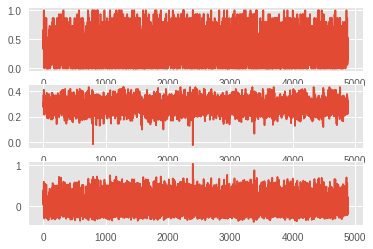

In [14]:
print("Explained variance score: " + str(explained_variance_score(y_test, y_predicted)))  # lower means: accounts less for variance in data
print("Mean squared error: " + str(mean_squared_error(y_test, y_predicted)))  # how close does the model get on average
print("Mean absolute error: " + str(mean_absolute_error(y_test, y_predicted)))  # are we biased?
print("Median absolute error: " + str(median_absolute_error(y_test, y_predicted)))  # outliers?
print("R^2: " + str(r2_score(y_test, y_predicted)))  # future predictions

print("Mean squared error to random1: " + str(mean_squared_error(y_test, y_test_random1)))  # how close does the model get on average
print("Mean absolute error to random1: " + str(mean_absolute_error(y_test, y_test_random1)))  # are we biased?


fig = plt.figure()
tmp = fig.add_subplot(3, 1, 1)
tmp = plt.plot(y_test)
tmp = fig.add_subplot(3, 1, 2)
tmp = plt.plot(y_predicted)
tmp = fig.add_subplot(3, 1, 3)
tmp = plt.plot([b - a for (a, b) in zip(y_predicted, y_test)])
